In [1]:
# prerun statements

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white', {'axes.linewidth': 1.0, 'axes.edgecolor': '.8'})
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from collections import OrderedDict
import statsmodels.api as sm
# import pyfolio as pf
# import alphalens as alen

import sys
sys.path.append('./lib/')
from backtest_func import *
from plot_performance import *
import base_func as bf

zz500, = bf.read_trade_data('zz500', data_path='backtest_data.h5')

benchmark_returns_zz500 = zz500.pct_change()
benchmark_returns_zz500.name = 'benchmark'


def quick(start, end, signal, mark_title):
    global global_settings
    hedged_period = global_settings['hedged_period']
    date_range = trade_date[start : end]
    benchmark = zz500[start : end]
    
    trade_returns, turnover_rates, positions_record, shares_record, transactions_record = backtest(date_range, signal, 
        global_settings['buy_commission'],  global_settings['sell_commission'],
        global_settings['effective_number'], global_settings['target_number'], 
        global_settings['transform_mode'])
    
    turnover_rates[0] = np.nan
    positions_record = pd.concat(positions_record, keys=date_range, names=['tradeDate'])
    shares_record = pd.concat(shares_record, keys=date_range, names=['tradeDate'])
    transactions_record = pd.concat(transactions_record, axis=1).stack().swaplevel().sort_index(level=0)
    
    # for quantopia format
    positions_record = positions_record.unstack()
    positions_record['cash'] = np.nan
    
    shares_record = shares_record.unstack()
    
    txn_date = transactions_record.index.get_level_values(0)
    txn_symbol = transactions_record.index.get_level_values(1)
    txn_amount = transactions_record.values
    txn_price = np.zeros(len(txn_date))
    for i in range(len(txn_date)):
        if txn_amount[i] >= 0:
            txn_price[i] = buy_stocks_price.loc[txn_date[i], txn_symbol[i]]
        else:
            txn_price[i] = sell_stocks_price.loc[txn_date[i], txn_symbol[i]]
    transactions_record = pd.DataFrame({'amount': txn_amount, 'price': txn_price, 'symbol': txn_symbol}, index=txn_date)
    
    perf = portfolio_performance(trade_returns, benchmark)
    hedged_returns = get_hedged_returns(trade_returns, benchmark, hedged_period)
    hedged_perf = portfolio_performance(hedged_returns, benchmark)
    plot_portfolio_performance(trade_returns, turnover_rates, hedged_returns, 
                               benchmark, perf, hedged_perf, mark_title)
    format_year_performance(trade_returns, benchmark, turnover_rates, mark_title)
    format_hedged_year_performance(hedged_returns, benchmark, mark_title+'_hedged')
    
    results = OrderedDict({
        'trade_returns': trade_returns, 
        'turnover_rates': turnover_rates, 
        'positions_record': positions_record, 
        'shares_record': shares_record, 
        'transactions_record': transactions_record, 
        'hedged_returns': hedged_returns
    })
    return results

def signal_analysis(signal, quantiles=5, price=close_price_backtest):
    signal_ = signal.stack()
    factor_data = alen.utils.get_clean_factor_and_forward_returns(signal_, price, quantiles=quantiles)

    alen.tears.create_full_tear_sheet(factor_data)
    alen.tears.create_event_returns_tear_sheet(factor_data, price)
    plt.show()

KeyError: 'No object named close_price_none in the file'

# Alpha008

In [2]:
# combine signals
bf.trade_data_path = 'signal_input_data.h5'
stocks_industry_L4, = bf.read_trade_data('stocks_industry_L4')


# Alpha-008
close_price_post, = bf.read_trade_data('close_price_post')
signal = -1 * close_price_post / bf.ts_mean(close_price_post, 39)

global_settings = {'effective_number': 100, 'target_number': 100, 'transform_mode': 0, 
                   'decay_num': 1, 'delay_num': 1, 'hedged_period': 60, 
                   'buy_commission': 2e-3, 'sell_commission': 2e-3}

signal = bf.outliers_revise(signal)
signal = bf.industry_neutralize(signal, stocks_industry_L4)
signal = bf.decay_linear(signal, global_settings['decay_num'])
signal008 = signal
print('caculate signal008 complete. \n')

caculate signal008 complete. 



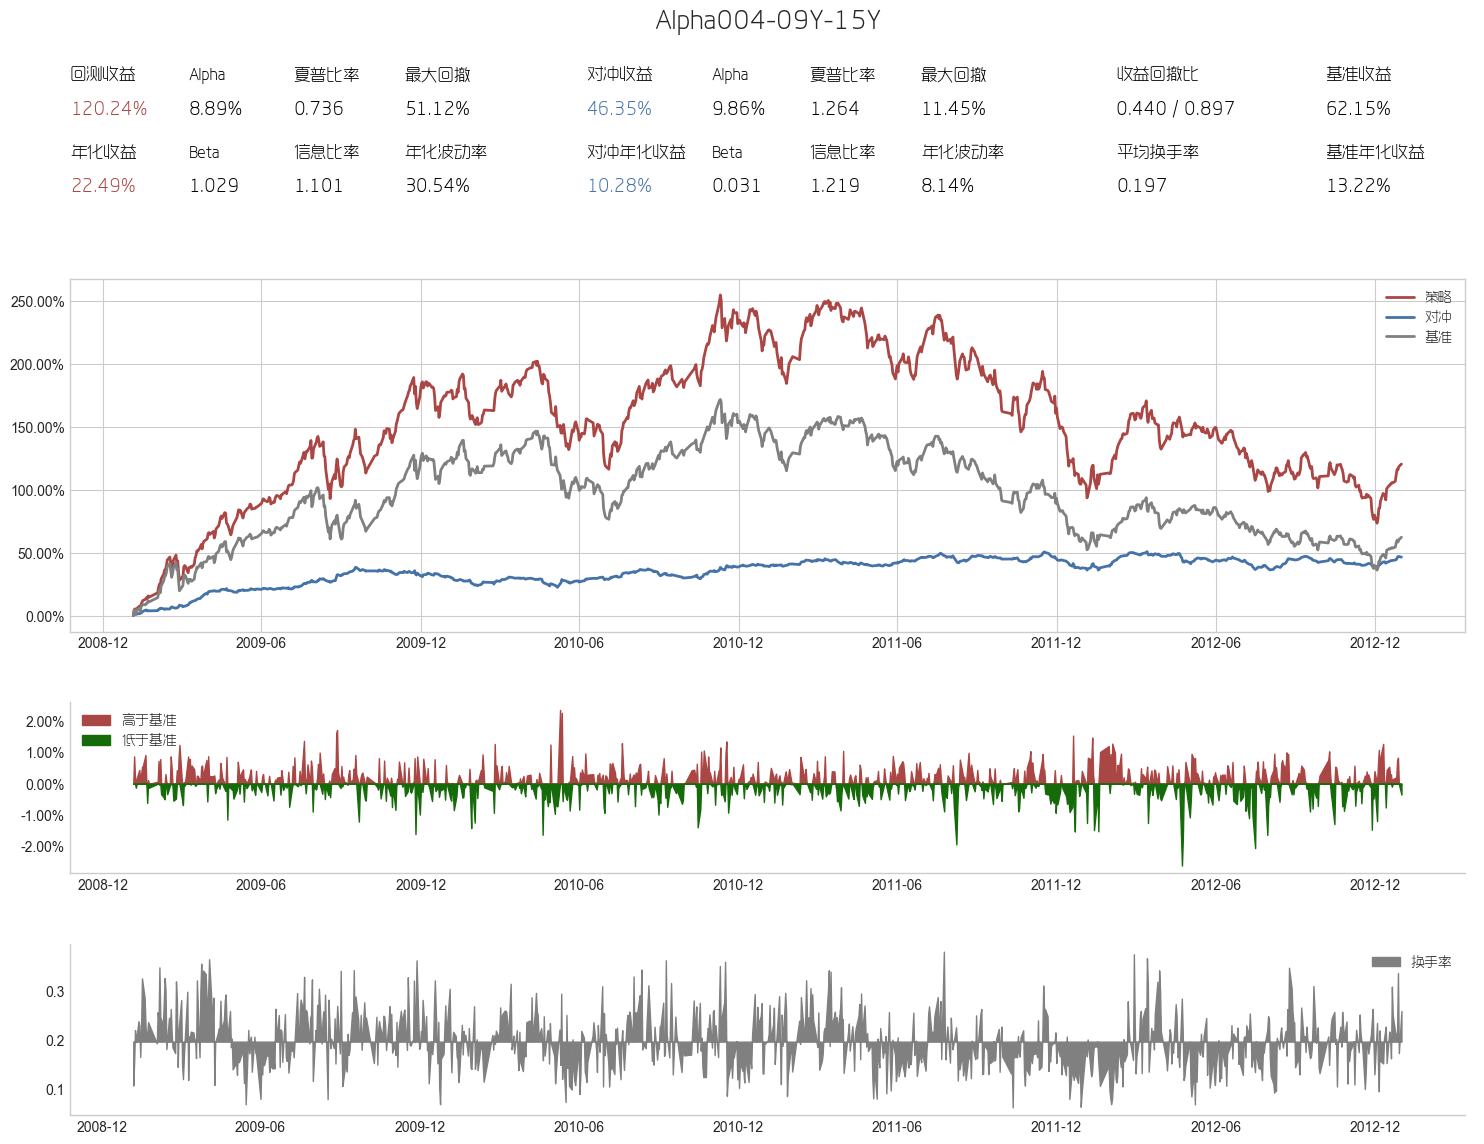

                         Alpha004-09Y-15Y


In [8]:
global_settings = {'effective_number': 100, 'target_number': 100, 'transform_mode': 0, 
                   'decay_num': 1, 'delay_num': 1, 'hedged_period': 60, 
                   'buy_commission': 2e-3, 'sell_commission': 2e-3}
results_IS_comb = quick('2009-01-01', '2012-12-31', signal, 'Alpha004-09Y-15Y')